In [27]:
import sys
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
from log_progress import log_progress

from bigclam_code.Extends import bigclam_orig
from algorithms import copra, LancichinettiBenchmark, walktrap, BigClam, NMF_clust, OCCAM, SAAC, NMI
from algorithms.benchmarks import get_realdatapaths, load_real_data
from Experiments import run_methods_model_data

In [28]:
methods = {#'BigClam-orig': lambda G, K: bigclam_orig(nx.adjacency_matrix(G).todense(), K),
           'COPRA': lambda G, K: copra(nx.adjacency_matrix(G).todense(), K),
           'NMF': lambda G, K: NMF_clust(nx.adjacency_matrix(G), K),
          ##'CFinder': lambda A, K, name: CFinder(A, K),
          ##'CPM': lambda A, K, name: [list(x) for x in get_percolated_cliques(nx.from_numpy_matrix(1.0 * (A != 0)), 5)]
           'walktrap': lambda G, K: walktrap(nx.adjacency_matrix(G).todense(), K),
           'OCCAM-SVD': lambda G, K:  OCCAM(nx.adjacency_matrix(G), K, W_mode='svd'),
           'OCCAM-LogLoss': lambda G, K:  OCCAM(nx.adjacency_matrix(G), K, W_mode='bigclam'),
           'OCCAM-NMF': lambda G, K:  OCCAM(nx.adjacency_matrix(G), K, W_mode='nmf'),
           #'OCCAM-SVD-l1': lambda G, K:  OCCAM(nx.adjacency_matrix(G), K, W_mode='svd', norm_mode='l1'),
           'OCCAM-LogLoss-l1': lambda G, K:  OCCAM(nx.adjacency_matrix(G), K, W_mode='bigclam', norm_mode='l1'),
           #'OCCAM-NMF-l1': lambda G, K:  OCCAM(nx.adjacency_matrix(G), K, W_mode='nmf', norm_mode='l1'),
           #'OCCAM-SVD-kmedians': lambda G, K:  OCCAM(nx.adjacency_matrix(G), K, W_mode='svd', clustering_mode="kmedians", verbose=1),
           #'OCCAM-LogLoss-kmedians': lambda G, K:  OCCAM(nx.adjacency_matrix(G), K, W_mode='bigclam', clustering_mode="kmedians", verbose=1),
           'SAAC-SVD': lambda G, K: SAAC(nx.adjacency_matrix(G), K, W_mode='svd'),
           'SAAC-LogLoss': lambda G, K: SAAC(nx.adjacency_matrix(G), K, W_mode='bigclam'),
           'SAAC-NMF': lambda G, K: SAAC(nx.adjacency_matrix(G), K, W_mode='nmf'),
        }

In [32]:
experiments_result = {}
datapath_list = get_realdatapaths()
keys = datapath_list.keys()
keys = ['twitter772']
for indx, name in enumerate(log_progress(keys, every=1)):
    #if name not in experiments_result_pd.index:
    #    continue
    print 'loading {} ...'.format(name),
    G, real_comms = load_real_data(datapath_list[name])
    print "\r{} data loaded E:{}, V:{}, K:{}".format(name, nx.number_of_edges(G), len(G), len(real_comms)),
    if(len(G) > 3000  or len(real_comms) > 50):
        print ' and skipped because too big',
        continue
    if(len(real_comms) < 2 or sum([len(x) for x in real_comms]) < len(G) * 0.05 or len(real_comms) > 0.5*len(G)):
        print ' bad data, skipped'
        continue
    #if(len(experiments_result) > 100):
    #    break
        
    real_k = max(len([x for x in real_comms if len(x) > 1 and len(x) > 0.4 * np.log(len(G))]), 2)
    nodes = list(G.nodes())
    inv_nodes = {v:i for i, v in enumerate(nodes)}
    real_comms_res = [[inv_nodes[i] for i in com if i in inv_nodes] for com in real_comms ]
    #A = nx.adjacency_matrix(G, nodelist=nodes)
    experiments_result[name] = {}
    for method_name in methods:
        print method_name,
        sys.stdout.flush()
        try:
            method_comms = methods[method_name](G, len(real_comms))
        except Exception as e:
            print('Some error occurred during {}: {} set quality to -1'.format(method_name, e))
            experiments_result[name][method_name] = -1
        try:
            experiments_result[name][method_name] = NMI(real_comms_res, method_comms)
        except Exception as e:
            print('Some error occurred during NMI: {} set quality to -1'.format(e))
            experiments_result[name][method_name] = -1
    print '\r', ' '*120, '\r',
    experiments_result_pd_new = pd.DataFrame.from_dict(experiments_result).T
    experiments_result_pd.to_csv('../data/experiments_result_temp_dump.csv')
experiments_result_pd_new = pd.DataFrame.from_dict(experiments_result).T
experiments_result_pd.to_csv('../data/experiments_result_dump.csv')

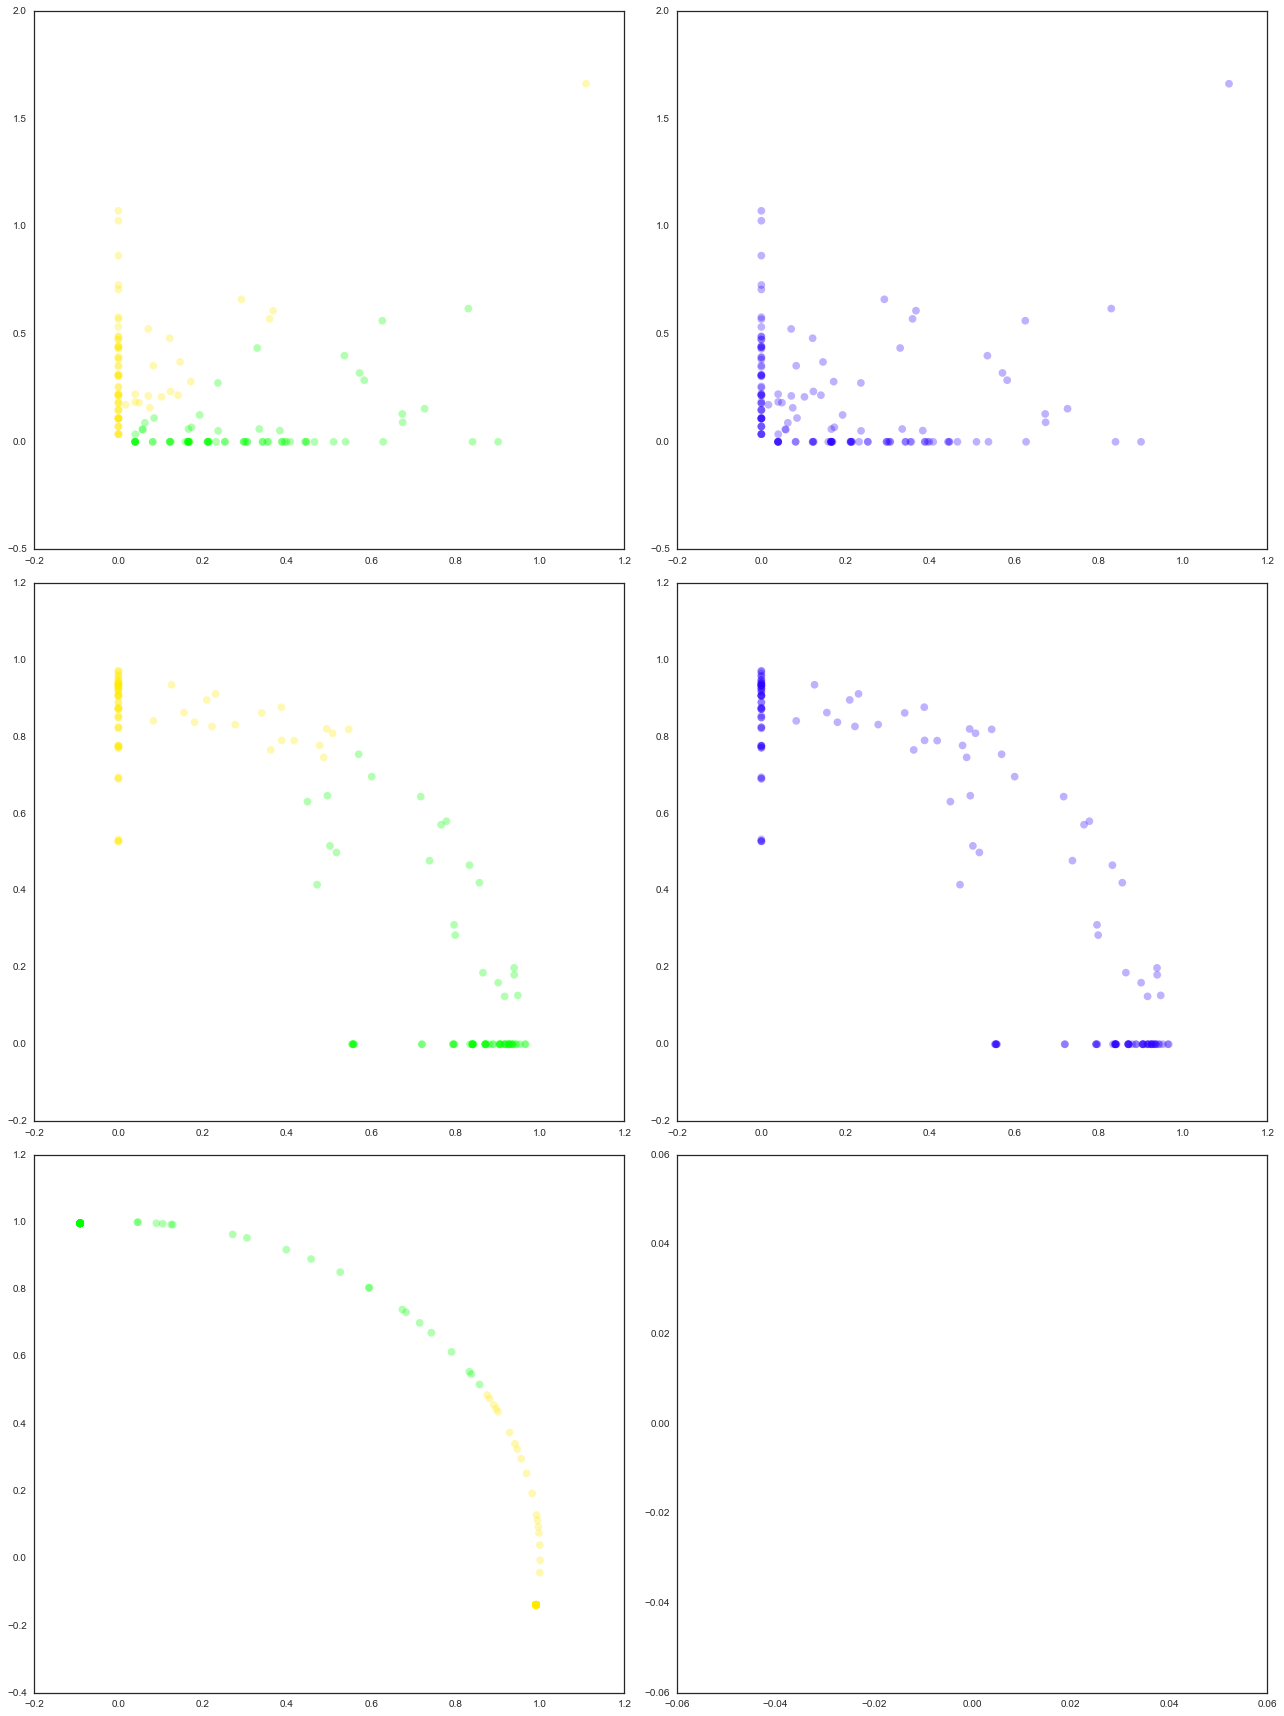

In [155]:
col = -np.ones((len(nodes),), dtype=int)
for i, indx in enumerate(res1):
    col[indx] = i+1
NUM_COLORS =2*len(res1)+1

cm = plt.get_cmap('gist_rainbow')
cols = np.array([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
cols[:, 3] = 0.3
cols[0, :] = 0
#cols = np.array(['k', 'r', 'g', 'b', 'm'])
col = cols[col]
s = 60

plt.figure(figsize=(18,24))
plt.subplot(321)
plt.scatter(info1["W"][:,0], info1["W"][:,1], c=col, linewidths=0, s=s)
plt.subplot(323)
plt.scatter(info1["hatW"][:,0], info1["hatW"][:,1], c=col, linewidths=0, s=s)
plt.subplot(325)
plt.scatter(info1["hatTheta"][:,0], info1["hatTheta"][:,1], c=col, linewidths=0, s=s)

col = -np.ones((len(nodes),), dtype=int)
for j, indx in enumerate(res2):
    col[indx] = j+len(res1)+1

col = cols[col]

plt.subplot(322)
plt.scatter(info2["W"][:,0], info2["W"][:,1], c=col, linewidths=0, s=s)
plt.subplot(324)
plt.scatter(info2["hatW"][:,0], info2["hatW"][:,1], c=col, linewidths=0, s=s)
plt.subplot(326)
plt.scatter(info2["hatTheta"][:,0], info2["hatTheta"][:,1], c=col, linewidths=0, s=s)
plt.tight_layout()

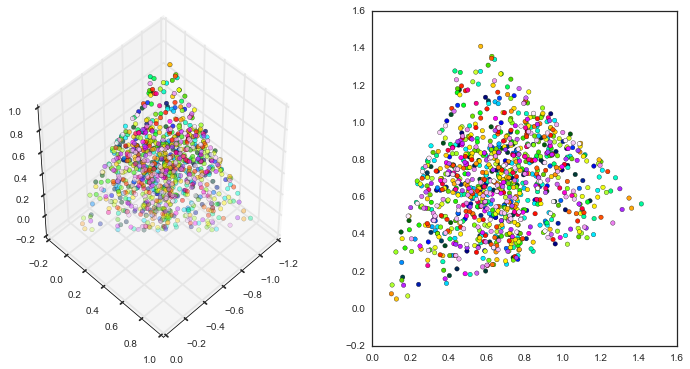

In [27]:
k=3
W = np.random.rand(1000, 3)
#W.sort()
tau=0.01
hatW = np.absolute(W) / (np.linalg.norm(W, ord=1, axis=1) + tau)[:,None]
res = hatW
scale = 1 / (1+tau)
res[:, 0] -= 1
to_nm1 = np.concatenate((-0.5*np.ones(shape=(k-1, 1)), 1*np.eye(k-1)), axis=1)
res = res.dot(to_nm1.T)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,res.shape[0])]

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.view_init(45, 45)
ax.scatter(hatW[:, 0], hatW[:, 1], hatW[:, 2], c=colors)

ax = fig.add_subplot(122)
ax.scatter(res[:, 0], res[:, 1], c=colors)
#plt.xlim([0,1])
#plt.ylim([0,1])

In [141]:
info.keys()

['tau',
 'projector',
 'hatTheta',
 'hatS',
 'hatW',
 'U',
 'W',
 'comm_matr',
 'Lambda']

In [34]:
hatW = info['hatW']

In [35]:
print hatW

[[ 0.85591869  0.42020672]
 [ 0.8699063   0.        ]
 [ 0.          0.77125608]
 [ 0.95198527  0.        ]
 [ 0.91521488  0.        ]
 [ 0.79503333  0.        ]
 [ 0.          0.92556534]
 [ 0.          0.90681093]
 [ 0.          0.9375224 ]
 [ 0.          0.87471708]
 [ 0.79375172  0.        ]
 [ 0.47713013  0.77718193]
 [ 0.96366907  0.        ]
 [ 0.          0.87204186]
 [ 0.56977014  0.75415876]
 [ 0.87013209  0.        ]
 [ 0.          0.92510849]
 [ 0.83966191  0.        ]
 [ 0.20956251  0.89554877]
 [ 0.15536123  0.86265934]
 [ 0.          0.69128428]
 [ 0.          0.90775701]
 [ 0.48677475  0.74617858]
 [ 0.90051193  0.16009583]
 [ 0.49386657  0.82013409]
 [ 0.          0.96467926]
 [ 0.55534383  0.        ]
 [ 0.49552836  0.6465157 ]
 [ 0.36130152  0.76548612]
 [ 0.92568193  0.        ]
 [ 0.96602745  0.        ]
 [ 0.          0.97133421]
 [ 0.54612619  0.8190258 ]
 [ 0.91583611  0.12445687]
 [ 0.55858586  0.        ]
 [ 0.          0.95833439]
 [ 0.23042209  0.91133652]
 

In [21]:
tau = info['tau']

In [36]:
cc = hatW[np.random.choice(hatW.shape[0], 2)]
km = kmedians(hatW, initial_centers=cc)
km.process()
hatS = np.array(km.get_medians())

In [37]:
hatS

array([[ 0.        ,  0.86265934],
       [ 0.87058758,  0.        ]])

In [196]:
math.floor(3.0 / 2)

NameError: name 'math' is not defined

In [184]:
np.random.choice(hatW.shape[0], k)

array([124,  90, 137])

In [185]:
for x in cc:
    print x
    print

[ 0.79327656  0.        ]

[ 0.          0.77626828]

